<a href="https://colab.research.google.com/github/irham235/Projek-Machine-Learning/blob/main/Membuat_Model_dengan_Data_Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files

# upload kaggle.json
upluoded = files.upload()

Saving kaggle (4).json to kaggle (4).json


In [ ]:
!mkdir -p ~/.kaggle/
!mv kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d 'emmanuelfwerr/london-weather-data'

100% 226k/226k [00:00<00:00, 519kB/s]
100% 226k/226k [00:00<00:00, 519kB/s]


In [ ]:
import zipfile
dataset_zip = zipfile.ZipFile('london-weather-data.zip', 'r')
dataset_zip.extractall()
dataset_zip.close()

In [ ]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM, Embedding
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [ ]:
df = pd.read_csv('london_weather.csv')
df.head()

,date,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth
0,19790101,2.0,7.0,52.0,2.3,-4.1,-7.5,0.4,101900.0,9.0
1,19790102,6.0,1.7,27.0,1.6,-2.6,-7.5,0.0,102530.0,8.0
2,19790103,5.0,0.0,13.0,1.3,-2.8,-7.2,0.0,102050.0,4.0
3,19790104,8.0,0.0,13.0,-0.3,-2.6,-6.5,0.0,100840.0,2.0
4,19790105,6.0,2.0,29.0,5.6,-0.8,-1.4,0.0,102250.0,1.0


In [ ]:
# sampel data
len(df)

15341

In [ ]:
# menemukan nilai null
df.isnull().sum()

date                   0
cloud_cover           19
sunshine               0
global_radiation      19
max_temp               6
mean_temp             36
min_temp               2
precipitation          6
pressure               4
snow_depth          1441
dtype: int64

In [ ]:
# menghapus nilai null dari dataframe
df_baru = df.dropna()
df_baru.isnull().sum()

date                0
cloud_cover         0
sunshine            0
global_radiation    0
max_temp            0
mean_temp           0
min_temp            0
precipitation       0
pressure            0
snow_depth          0
dtype: int64

In [ ]:
len(df_baru)

13843

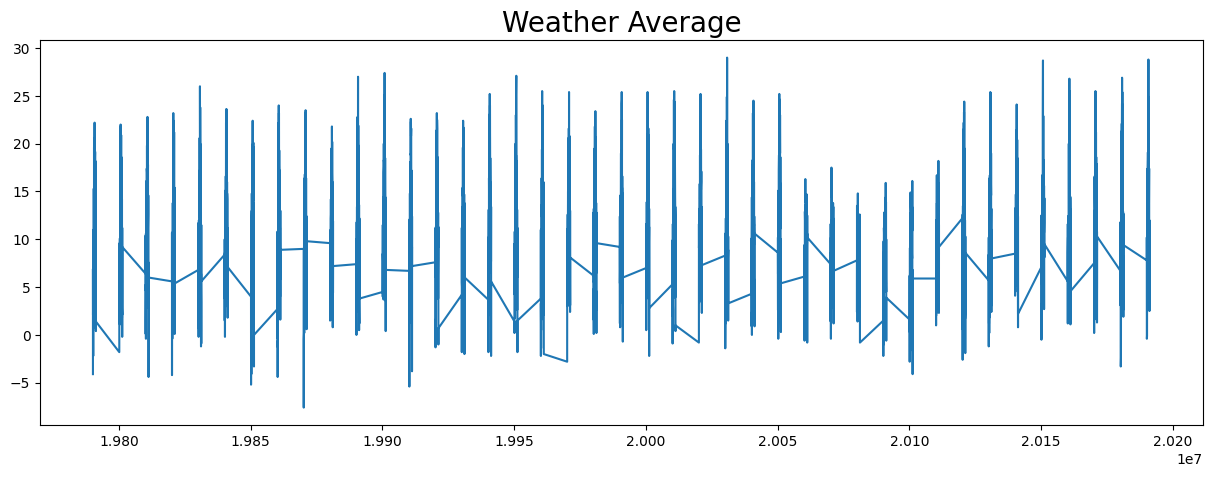

In [ ]:
dates = df_baru['date'].values
temp = df_baru['mean_temp'].values

plt.figure(figsize=(15,5))
plt.plot(dates, temp)
plt.title('Weather Average',
          fontsize=20);

In [ ]:
date_latih, date_test, temp_latih, temp_test = train_test_split(dates, temp, test_size=0.2, shuffle=False)

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series,axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1,shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[-1:]))
  return ds.batch(batch_size).prefetch(1)

In [ ]:
train_set = windowed_dataset(temp, window_size=60, batch_size=100, shuffle_buffer=1000)
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(60, return_sequences=True),
    tf.keras.layers.LSTM(60),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [ ]:
threshold_mae = (df_baru['mean_temp'].max() - df_baru['mean_temp'].min()) * 10/100
print(threshold_mae)

3.66


In [ ]:
# menggunakan callback
from keras.callbacks import Callback
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')< threshold_mae):
      print("\nStop")
      self.model.stop_training = True
callbacks = myCallback()

In [ ]:
history = model.fit(train_set,
                    epochs=100,
                    validation_data=train_set,
                    callbacks=[callbacks],
                    verbose=2)

Epoch 1/100

Stop
138/138 - 5s - loss: 1.0831 - mae: 1.5140 - val_loss: 1.0814 - val_mae: 1.5118 - 5s/epoch - 33ms/step


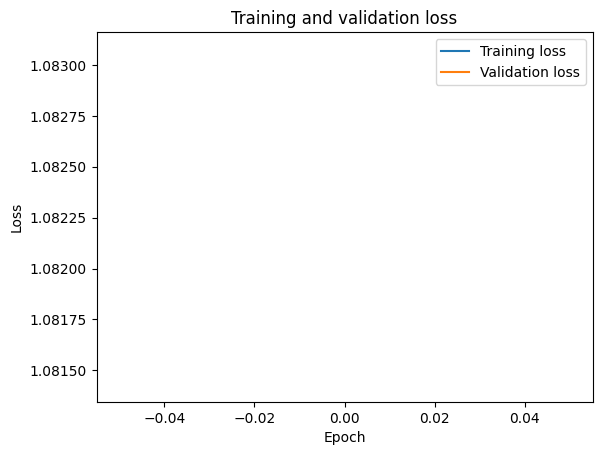

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
mae = history.history['mae']
val_mae = history.history['val_mae']
loss = history.history['loss']
val_loss = history.history['val_loss']

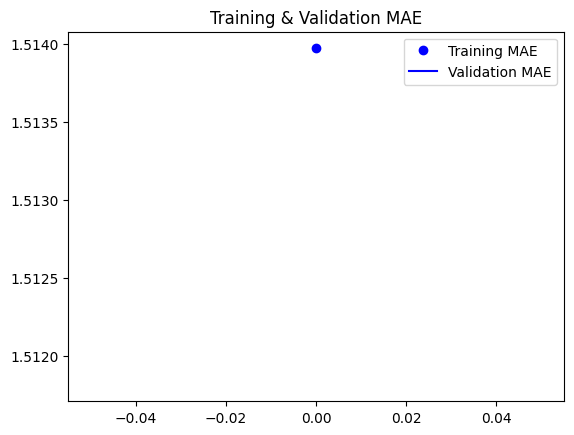

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.plot(mae, 'bo', label='Training MAE')
plt.plot(val_mae, 'b', label='Validation MAE')
plt.title('Training & Validation MAE')
plt.legend()
plt.figure()
plt.show()